Length of the corpus is:: 1203
once there was a shepherd boy who had to look after a flock of
sheep. one day, he felt bored and dec
['once', 'there', 'was', 'a', 'shepherd']
boy


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
2/2 [==============================] - 3s 623ms/step - loss: 4.6187 - accuracy: 0.0529 - val_loss: 4.8478 - val_accuracy: 0.0909
Epoch 2/10
2/2 [==============================] - 0s 47ms/step - loss: 4.2598 - accuracy: 0.0913 - val_loss: 5.2372 - val_accuracy: 0.0909
Epoch 3/10
2/2 [==============================] - 0s 44ms/step - loss: 3.8544 - accuracy: 0.1346 - val_loss: 5.1052 - val_accuracy: 0.0909
Epoch 4/10
2/2 [==============================] - 0s 43ms/step - loss: 3.5176 - accuracy: 0.2500 - val_loss: 4.7406 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 0s 43ms/step - loss: 3.1597 - accuracy: 0.3558 - val_loss: 5.1609 - val_accuracy: 0.0909
Epoch 6/10
2/2 [==============================] - 0s 45ms/step - loss: 2.2869 - accuracy: 0.3654 - val_loss: 5.5517 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 0s 49ms/step - loss: 1.9668 - accuracy: 0.4279 - val_loss: 6.0456 - val_accuracy: 0.0000e+00
Epoch 8/10
2/2

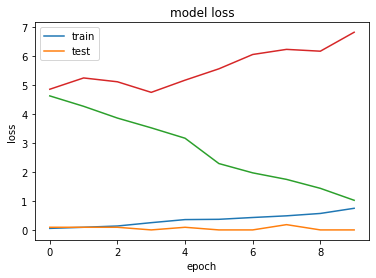

boy
[2.79285433e-03 1.14355356e-01 6.50059655e-02 5.99238265e-04
 2.57165972e-02 5.45112358e-04 5.23097580e-04 2.63136462e-03
 6.22093910e-04 6.54353789e-05 2.99125095e-04 1.52047107e-03
 4.75805136e-04 6.35215081e-04 4.78283939e-04 8.09302001e-05
 5.06891124e-03 9.90484958e-04 1.64702476e-04 6.69493340e-03
 3.54147414e-05 5.35460276e-05 3.83512321e-04 8.14123952e-04
 5.11715887e-04 6.00494532e-05 4.41965676e-04 1.06425185e-04
 1.78100879e-03 4.83034673e-04 1.40634133e-03 9.83844977e-04
 1.91331812e-04 1.13075629e-01 7.84614880e-04 1.28745436e-04
 1.20970537e-03 3.33773741e-03 3.84012912e-03 4.46775742e-02
 3.90476966e-03 4.32178704e-03 1.41157827e-04 1.95271079e-03
 3.97585779e-02 3.65482469e-04 2.76989490e-03 7.46053920e-05
 1.15781710e-01 5.18619455e-03 2.73328857e-04 2.19387279e-04
 1.72477798e-03 3.61519679e-02 8.57984996e-04 2.51002004e-03
 2.59823311e-04 9.12422256e-04 1.94701031e-04 1.69709150e-04
 3.70521587e-03 1.30245651e-04 3.15386656e-04 3.39734223e-04
 1.04794810e-02 2.65

KeyboardInterrupt: ignored

In [ ]:
# Import required modules
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Bidirectional, Attention
import pickle
from keras.optimizers import RMSprop
import tensorflow as tf

# Import dataset
path = 'data.txt'
text = open(path).read().lower()
print('Length of the corpus is::', len(text))

print(text[: 100])

# Tokenize
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

# Get unique words and index dictionary
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

# Create a set of next and previous words
LENGTH_WORD = 5
next_words = []
prev_words = []
for j in range(len(words) - LENGTH_WORD):
    prev_words.append(words[j:j + LENGTH_WORD])
    next_words.append(words[j + LENGTH_WORD])

print(prev_words[0])
print(next_words[0])

# Create X and Y to store word projections
X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_words)), dtype=bool)

Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1


query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=104)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
model = Sequential()
model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)

# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = model(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = model(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_seq_encoding, query_value_attention_seq])


# model = Sequential()
# model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))), return_sequences=True)
# model.add(Dense(len(unique_words)))
# model.add(Activation('softmax'))
# optimizer = RMSprop(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history
# Save the model
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

# Accuracy plots
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# # add new attention layer
# model.add(Attention(LENGTH_WORD))
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history


# Save the model


# predict the next word
def predict_next_word():
    while True:
        text = input()
        if text == 'exit':
            break
        else:
            token_list = tokenizer.tokenize(text.lower())
            X = np.zeros((1, LENGTH_WORD, len(unique_words)))
            for i, word in enumerate(token_list):
                X[0, i, unique_word_index[word]] = 1
            prediction = model.predict(X, verbose=0)[0]
            print(prediction)
            print(unique_words[np.argmax(prediction)])
            print(unique_words[heapq.nlargest(5, range(len(prediction)), prediction.take)])
predict_next_word()